### Name and source statement

Enter your name (in the requested format, please) and your github handle. Also add a statement on your sources. You are allowed to look up things and use AI tools, but you need to honestly state what you used and how, e.g. to resolve errors, understand something better, or generate (partial) solutions. This is required, don't forget. You don't need to report on the use of AI tools that are required as part of the assignment.

In [132]:
# Fill in your name using the given format, GitHub handle, and sources
# Fill in your name using the given format, GitHub handle, and sources
your_name = "BRESCIA, FRANCESCO"
github_handle = "francescobrescia-tue"
statement = """
            Jupiter Notebooks from Labs as a guideline for the exercises and the code structure
            TensorFlow Documentation to understand the basics functions of the library, its functionalities and the scope of relative parameters  
            Skit-learn Documentation to understand the basics functions of the library, its functionalities and the scope of relative parameters 
            Stack Overflow to find solutions to specific problems and to solve bugs 
            Github Copilot to understand well how some functions are implemented and how the code is structured, but also to generate partial solutions
            """

# Before submission, set this to True so that you can render and verify this notebook without retraining all the deep learning models.
# All models will be loaded from file instead.
stop_training = True

# Machine Learning Engineering - Assignment 3

Indoor scene recognition is a challenging open problem in high level vision. Most scene recognition models that work well for outdoor scenes perform poorly in the indoor domain. The main difficulty is that while some indoor scenes (e.g. corridors) can be well characterized by global spatial properties, others (e.g., bookstores) are better characterized by the objects they contain. More generally, to address the indoor scenes recognition problem we need a model that can exploit local and global discriminative information.

The initial [dataset](https://web.mit.edu/torralba/www/indoor.html) contains 67 indoor categories, and a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. 

Your task is to design a model that can successfully identify a given scene. You'll also extend the dataset with your own images and use your own model to predict them. This assignment only has a few open questions and will be graded mainly on your thoroughness, creativity and the performance of your models.

<img src="https://www.researchgate.net/publication/330944743/figure/fig3/AS:723850107052032@1549590722180/Some-example-images-of-Scene-67-database-The-dataset-totally-has-67-indoor-scene.png" width="800">


In [133]:
import validation

In [134]:
# For use in colab
if 'google.colab' in str(get_ipython()):
  !pip install -U -q openml dill

In [135]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml
import os
import tensorflow

from packaging import version
tensorflow_version = tensorflow.__version__
if version.parse(tensorflow_version) < version.parse("2.15.0"):
    print("Tensorflow version is <2.15. This will likely work but we recommend updating to 2.15 or higher".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. However, if you feel confident using PyTorch, that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers. We'll provide help during the assignment where we can.

### Using GPUs
Using GPUs will be useful in this assignment since it will speed up training a lot. If you have a local GPU, you can use that. If you don't, we recommend Google Colab of Kaggle Kernels. If you use these services, be careful about resource usage. The free version of Colab may not have GPUs ready all the time, and may deny you a GPU when you have used them a lot. Also the paid Colab version has resource limits and will consume resources whenever your notebook is active (even if you're not running anything.)

Take this into account in your planning, so that you don't do all your training at the last moment and are locked out right before the deadline.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you. Be sure to upload all .keras, .h5 and .p files, as well as any .json files created (these are created only for large models). For the third question you will also need to store new images in your repository and submit them to GitHub.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell. 

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
  * The cell below does this programmatically for you (you'll need to uncomment and run it)
* Fill in the path to your assignment folder below
  * It's likely `base_dir = '/content/drive/My Drive/assignment-3-name'`
  * 'name' will likely be your github handle

In [136]:
# Uncomment the following line to run in Google Colab
# This will link the notebook to your Google drive to store your models and cache the dataset.
# This will probably ask you to click on a link to get a verification code.
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [137]:
# Define where the models should be stored. Use './' for the current directory (your assignment repository).
base_dir = './'

### Verification and submission

There are a few things to consider before submission:
* If you use Colab, you need to download the notebook and all the models from your Google Drive to our assignment repository. 
* Models should be stored in the main directory, next to your notebook.
* Your own images should be stored in folders, one folder per class, as explained in part 3.
* Run the notebook locally, making sure that you have set `stop_training = True` in the first cell to avoid retraining all models. Also comment out any Colab-specific code in the cells above.
* Set `base_dir` back to your local directory where the files are, this should be `base_dir = './'`
* Again, don't wait until the last moment to submit.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are. We provide code below that stores the model efficiently. Smaller models are simply stored entirely to disk as one h5 file. For larger models, we will only store the weights (h5 file) and structure (json file), and ignore the state of the optimizer. In any case, the weights alone should not take more than 100MB of storage. Take this into account especially for loading pre-trained models in the last question. Bigger pre-trained models are not always better - in fact they will easily overfit. Make sure that your model weights take less than 100MB of storage.
* When questions ask you to provide an explanation, it should be less than 600 characters long, or as long as specified. Make sure that you don't violate this constraint.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance.
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters", yes: "More layers mean more parameters").
* Part of your grade depends on how well your models perform. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance, with the top grade awarded to the best model in class. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to check that all the results are included.
* The dataset we will use is quite large and can take a while to download and cache for the first time. Once cached, it should load fast. Even if you use Colab, at least run the notebook once locally when you start doing the assignment (i.e., now). That way the dataset will be cached so that you can do the verification faster.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model. Don't say 'I tried every possible option and this is the best I found', but rather 'I tried X because I think that Y' and then interpret the results and what you learned from them'.
* **Be original. We will check for plagiarism between student submissions.**

## Getting the data
We'll download the data from OpenML. This will take a bit of time the first time (about 6 minutes).
The images are stored in an 'Images' folder, which has one subfolder for every class, each containing all images (as JPGs) for that class.

In [138]:
# Loading the data. Don't change these variables.
from sklearn.model_selection import train_test_split
from pathlib import Path

openml_dataset = openml.datasets.get_dataset(45923)
if not (Path(openml_dataset.data_file).parent / "Images").exists():
    openml_dataset = openml.datasets.get_dataset(45923, download_all_files=True)
    
df, *_ = openml_dataset.get_data()

# Local directory with the images
data_dir = os.path.join(os.path.dirname(openml_dataset.data_file), "Images")

# Splitting the data
df_train, df_valid = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Class_name'])


C:\Users\Utente\AppData\Local\Temp\ipykernel_34572\3284963490.py:5: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  openml_dataset = openml.datasets.get_dataset(45923)


The main dataframe itself only holds the location of each image, the class name, and class number.

In [139]:
df

,Filename,Class_name,Class_encoded
0,airport_inside/airport_inside_0358.jpg,airport_inside,0
1,airport_inside/airport_inside_0071.jpg,airport_inside,0
2,airport_inside/airport_inside_0004.jpg,airport_inside,0
3,airport_inside/airport_inside_0194.jpg,airport_inside,0
4,airport_inside/airport_inside_0458.jpg,airport_inside,0
...,...,...,...
15615,winecellar/wine_cellar_05_16_altavista.jpg,winecellar,66
15616,winecellar/bodega_25_05_altavista.jpg,winecellar,66
15617,winecellar/r_4.jpg,winecellar,66
15618,winecellar/cave_champagne_05_11_altavista.jpg,winecellar,66


In [140]:
import pandas as pd

# Step 1: Define the maximum number of samples per class
max_samples_per_class = 300

# Step 2: Create an empty DataFrame for the balanced dataset
df_train_balanced = pd.DataFrame()

# Step 3: Sample up to max_samples_per_class instances from each class
for class_name in df_train['Class_name'].unique():
    # Check if the class has more than max_samples_per_class instances
    if (df_train['Class_name'] == class_name).sum() > max_samples_per_class:
        df_class_sampled = df_train[df_train['Class_name'] == class_name].sample(n=max_samples_per_class, random_state=0)
    else:
        df_class_sampled = df_train[df_train['Class_name'] == class_name]
    df_train_balanced = pd.concat([df_train_balanced, df_class_sampled], axis=0)

# Shuffle the dataset since it's currently sorted by class
df_train_balanced = df_train_balanced.sample(frac=1, random_state=0).reset_index(drop=True)

# Optionally, check the new class distribution
print("Class distribution after setting maximum elements per class:", df_train_balanced['Class_name'].value_counts())


Class distribution after setting maximum elements per class: Class_name
bedroom          300
inside_subway    300
toystore         300
kitchen          300
subway           300
                ... 
inside_bus        92
lobby             91
hospitalroom      91
greenhouse        91
elevator          91
Name: count, Length: 67, dtype: int64


The class distribution is quite unbalanced.

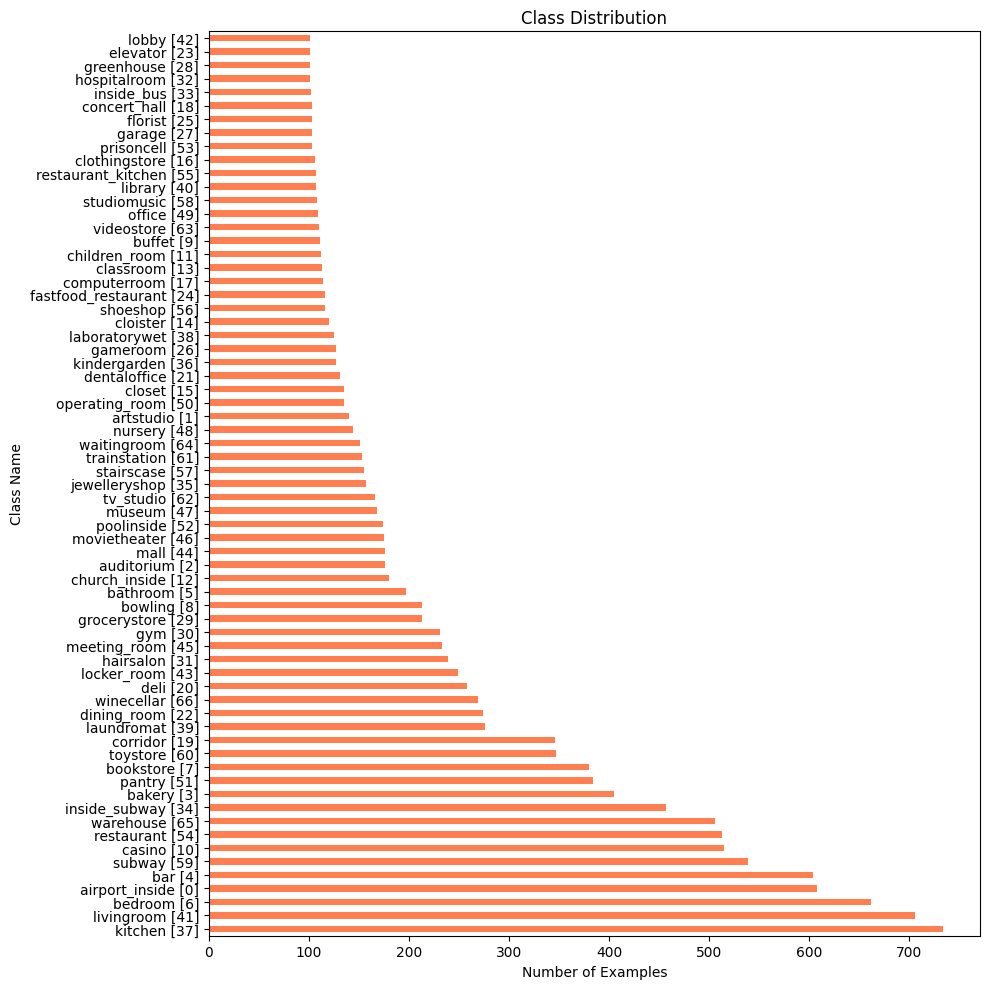

In [141]:
# Assuming your DataFrame is named 'df'
df['Combined_Label'] = df['Class_name'] + ' [' + df['Class_encoded'].astype(str) + ']'
class_counts = df['Combined_Label'].value_counts() # Count class occurrences

# Generate the bar plot
plt.figure(figsize=(10, 10)) 
class_counts.plot(kind='barh', color='coral')
plt.xlabel('Number of Examples')
plt.ylabel('Class Name')
plt.title('Class Distribution')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

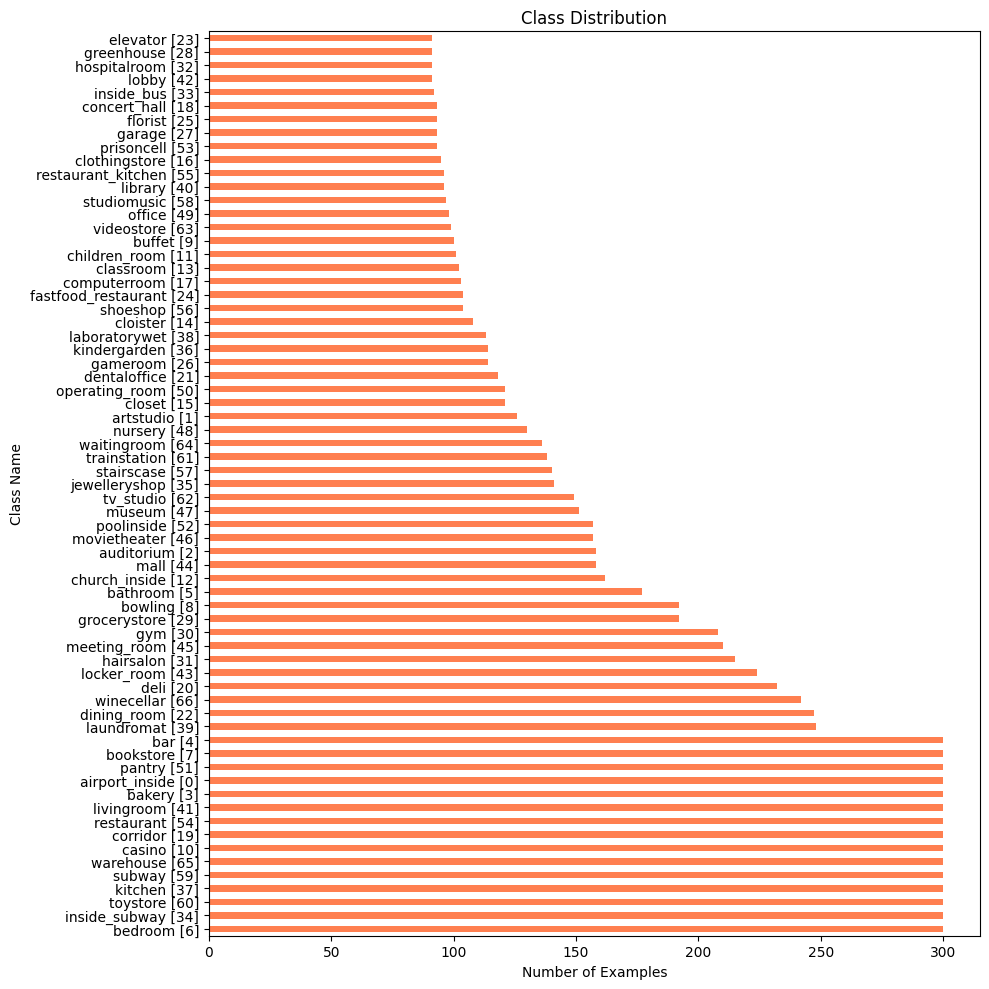

In [142]:
# Assuming your DataFrame is named 'df'
df_train_balanced['Combined_Label'] = df_train_balanced['Class_name'] + ' [' + df_train_balanced['Class_encoded'].astype(str) + ']'
class_counts = df_train_balanced['Combined_Label'].value_counts() # Count class occurrences

# Generate the bar plot
plt.figure(figsize=(10, 10)) 
class_counts.plot(kind='barh', color='coral')
plt.xlabel('Number of Examples')
plt.ylabel('Class Name')
plt.title('Class Distribution')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Data generator
Image datasets such as these are large. For efficiency reasons, we won't preprocess all images beforehand, nor store them all in memory. We'll use a data generator that fetches batches of images and then converts them on the fly.

Note that we build two generators: one for training data and one for validation data. They will each return batches of 128x128 pixel images and their corresponding labels. The image will be resizes (squashed) to fit these dimensions. The pixel values are integers between 0 and 256.

In [143]:
# Helper variables to make our code cleaner.
IMG_SIZE = 128
NUM_CLASSES = 67

In [144]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
train_generator = datagen_train.flow_from_dataframe(dataframe=df_train_balanced,
                                            directory=data_dir,
                                            x_col="Filename", y_col="Class_encoded",
                                            class_mode="categorical",
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=32)

datagen_valid = ImageDataGenerator() # Don't augment the validation data!
valid_generator = datagen_valid.flow_from_dataframe(dataframe=df_valid,
                                            directory=data_dir,
                                            x_col="Filename", y_col="Class_encoded",
                                            class_mode="categorical",
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=32)

Found 11622 validated image filenames belonging to 67 classes.
Found 1562 validated image filenames belonging to 67 classes.


Important: Data generators will infer an ordering of the classes from the data. If you use it to train a model, and want to make predictions on entire new data (with a different generator), you must use the exact same class ordering. The ordering is stored below in `classes_ordered`. You'll need it in Part 3 of this assignment when you create a generator for your own data.

In [145]:
class_mapping = train_generator.class_indices
classes_ordered = sorted(class_mapping, key=class_mapping.get)

### Peek at the data
It's always good to take a close look at the images and see what properties they have that we need to take into account when designing a neural net. We'll plot 10 images from the  training sets. Observe the original image sizes, since not all images share the same height and width.

In [146]:
def plot_images(X, y, toRGB=True, title = None):
    fig, axes = plt.subplots(1, len(X),  figsize=(15,45), layout='constrained')
    if title:
        fig.suptitle(title, fontsize=14)
    for n in range(len(X)):
        if toRGB:
            img_rgb = cv2.cvtColor(X[n], cv2.COLOR_BGR2RGB) # Convert BGR to RGB
        else:
            img_rgb = X[n]
        axes[n].imshow(img_rgb)
        axes[n].set_xlabel(y[n], fontsize=14)
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show()

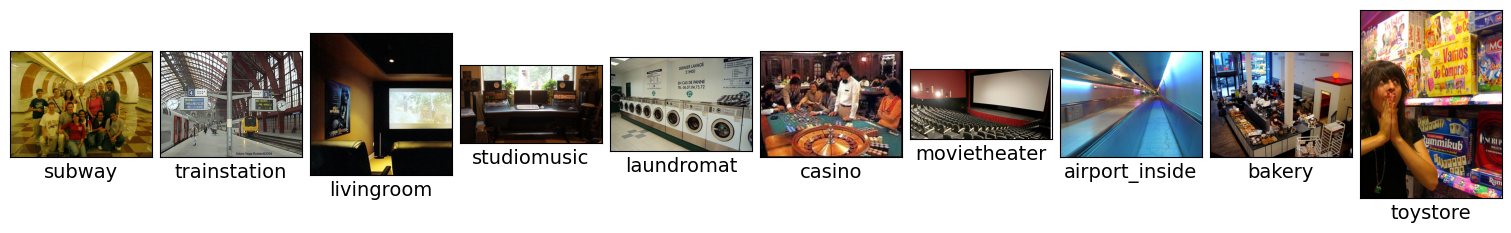

In [147]:
import cv2
df_train_rsub = df_train[:10]
X_sub_train = [cv2.imread(os.path.join(data_dir, filename)) for filename in df_train_rsub['Filename'].to_numpy()]
y_sub_train = df_train_rsub['Class_name'].to_numpy()
plot_images(X_sub_train, y_sub_train)

This is the output of the training data generator for the same images.

Found 14058 validated image filenames belonging to 67 classes.


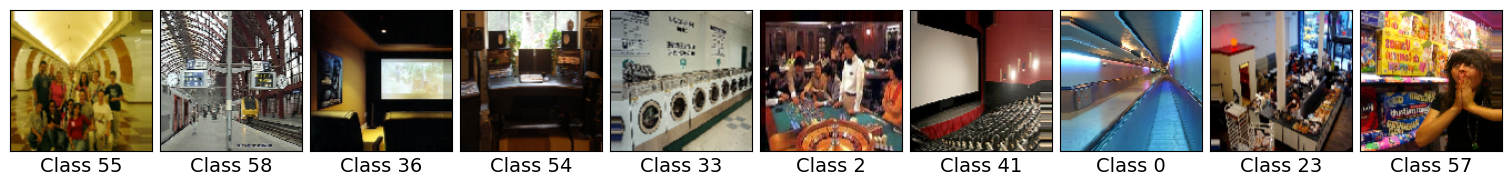

In [148]:
# Variant of the data generator that does not shuffle the data
train_generator_noshuffle = datagen_train.flow_from_dataframe(dataframe=df_train, directory=data_dir, x_col="Filename", y_col="Class_encoded",
                                            class_mode="categorical", target_size=(IMG_SIZE, IMG_SIZE), shuffle=False, batch_size=10)
x, y = next(train_generator_noshuffle)
x_int = [xs.astype('uint8') for xs in x] # Convert from float to uint8 for plotting
y_int = ["Class {}".format(np.argmax(ys)) for ys in y] # Convert from one-hot to integer encoding
plot_images(x_int, y_int, False)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [149]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.utils import plot_model
from IPython.core import page
from IPython.display import display
from PIL import Image
page.page = print

# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# Helper function to format answers
def print_answer(ans):
    output = ""
    for line in ans.splitlines()[0:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)


def load_model_from_file(base_dir, name, extension='.keras'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'model_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.keras'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    if size > 100*1024*1024:
        shout("Warning: Model larger than 100MB! You won't be able to upload it to GitHub.")

# Evaluation harness
def run_evaluation(name, model_builder, base_dir, train=True, data=None,
                   train_generator=None, valid_generator=None, epochs=3, batch_size=32,
                   steps_per_epoch=60, validation_steps=30,
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'model_1'
    model_builder -- function that returns an (untrained) model. The model must
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a
                     model summary, and a 'save' function that saves the model
                     to disk.
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with. Set batch size to None when using a generator.
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    print_model -- whether or not to print the model
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}

    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if train_generator:
            history = model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                                validation_data = valid_generator, validation_steps = validation_steps,
                                batch_size=batch_size, epochs=epochs, verbose=1)
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    lc = lc.set_index(lc.index + 1)
    print("Max val score: {:.2f}%".format(lc['val_accuracy'].max()*100))

    # Plot
    fig, ax1 = plt.subplots(figsize=(10,4))
    lc[['loss', 'val_loss']].plot(ax=ax1, lw=2, style=['b:', 'b-'], legend=False)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss', color='b')
    ax2 = ax1.twinx()
    lc[['accuracy', 'val_accuracy']].plot(ax=ax2, lw=2, style=['r:', 'r-'], legend=False)
    ax2.set_ylabel('accuracy', color='r')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.tight_layout()
    plt.show()

    if print_model:
        print(model.summary())
    #plot_model(model, to_file=os.path.join(base_dir,name+'.png'))
    #img = Image.open(os.path.join(base_dir,name+'.png'))
    #img = img.rotate(90, expand=True)  # expand=True to accommodate the new shape
    #width, height = img.size
    #new_height = 300
    #new_width = int(new_height * width / height)
    #img = img.resize((new_width, new_height), Image.LANCZOS)
    #display(img)

#### Toy example
See how the models are stored locally and how the evaluation is done. Also note how the run_evaluation function is called.
You can remove or comment out this code before submission if you like.

Max val score: 5.73%


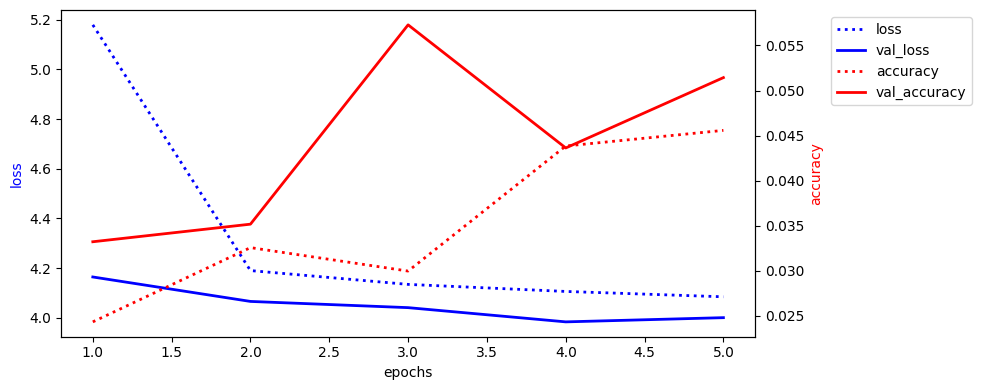

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 global_average_pooling2d_2  (None, 32)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 67)                2211      
                                                                 
Total params: 12355 (48.26 KB)
Trainable params: 12355 (48.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [150]:
# Toy usage example
from tensorflow.keras import models, layers

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Speed up training by training on 1/5th of the data
steps_per_epoch= train_generator.n // train_generator.batch_size // 5

# First build and store
run_evaluation("toy_example", build_toy_model, base_dir,
               train=True, train_generator=train_generator, valid_generator=valid_generator, epochs=5,
               batch_size=None, steps_per_epoch=steps_per_epoch,
               validation_steps = valid_generator.n//valid_generator.batch_size)

With train=False: load from file and report the same results without rerunning


Max val score: 5.73%


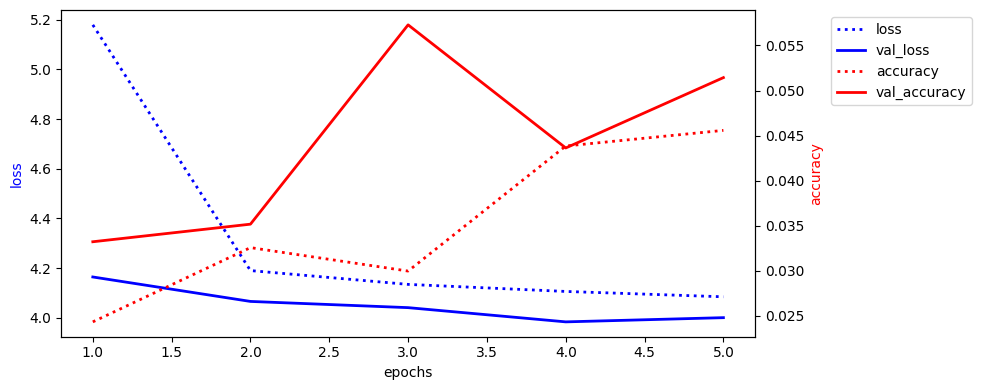

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 global_average_pooling2d_2  (None, 32)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 67)                2211      
                                                                 
Total params: 12355 (48.26 KB)
Trainable params: 12355 (48.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [151]:
# Toy usage example
run_evaluation("toy_example", build_toy_model, base_dir, train=False)

## Part 1. Design a convolutional neural network (14 points)
- Build a sequential convolutional neural network to distinguish the 67 types of indoor scenes
- Try to achieve the best validation accuracy you can. You should at least get 50% validation accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. You can use different batch sizes and number of epochs, but keep the number of epochs smaller than 100.
- You should train the model from scratch. Hence, you should NOT use any pretrained models (we'll do that in the next part).
- Augment the preprocessed training data (e.g. by implementing a new version of the ImageDataGenerator defined above). You can explore using image shifts, rotations, zooming, flips, color augmentation, etc. What works well, and what does not? Reason about what might work or not on these images.
- Implement a function `build_model_1` that returns the (untrained) model. Evaluate the model with the augmented data using the 'run_evaluation' function.
- Store the trained model as 'model_1'. Copy the observed validation accuracy in 'valid_accuracy_1'. We'll also store the full learning curves.
- Explore all relevant design decisions (batch size, number of convolution and dense layers, selection of activation functions, filter sizes, strides, padding techniques, regularization,...).
- Add a description of your design choices in 'answer_1': explain what you did, why, and what the effect is on performance. You are allowed **600** characters for this answer (but don’t ramble).
- Your submitted notebook should contain:
  - your model implementation in `build_model_1`
  - the result (plot) of running `run_evaluation`
  - the reported performance copied into `valid_accuracy_1`
  - your explanation in `answer_1`
- 50% of the grade will be based on your model architecture and your explanation. The other 50% depends on the model's performance, where a 50% validation accuracy will get you a good grade, and full marks will be given to the best (correct and fair) model in class.

Hint: It might be smart to experiment different architectures by first training them on part of the data as shown in the toy example. However, the final model should be trained on all training data.

In [152]:
from tensorflow.keras import layers, models

Max val score: 57.62%


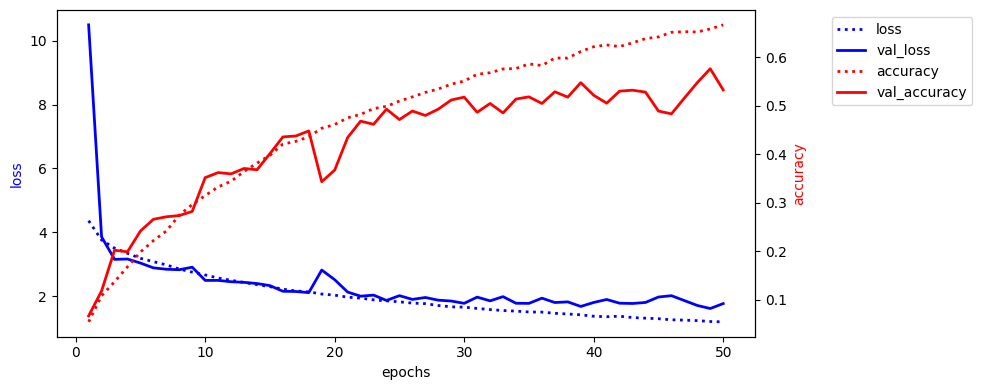

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_19 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_20 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                      

In [153]:
def build_model_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model
  

run_evaluation("model_1", build_model_1, base_dir,
               train=True, train_generator=train_generator, valid_generator=valid_generator, epochs=50,
               batch_size=None, steps_per_epoch=train_generator.n//train_generator.batch_size,
               validation_steps = valid_generator.n//valid_generator.batch_size)


valid_accuracy_1 = 57.62
print("Model 1 accuracy:", valid_accuracy_1)

answer_1 = """
           The model is able to effectively capture the deepest and most complex features of the dataset due to 
           its architecture consisting of 4 convolutional blocks, where in each of them a double convolution is 
           applied using two filters of the same size, and then a feed-forward neural network is added. Batch 
           normalization stabilises the training, keeping the normalization of the data within the batch through 
           the network. The use of dropout combats overfitting, which is particularly important given the depth 
           of the model. Together, these choices ensure robust learning and generalisation across classes.
           """
print("Answer is {} characters long".format(len(answer_1)))

In [154]:
validation.signature_unchanged(build_model_1)

## Part 2. Transfer learning (8 points)
- Import a pretrained model. You can choose any model you like, but be careful that it is not too large (it should be less than 100MB, or you won't be able to upload it to GitHub). [See here](https://keras.io/applications/). Take some time to study the range of pretrained models that exist. When in doubt, we recommend the MobileNet and EfficientNet models pretrained on ImageNet. We know that the 100MB limit will also limit how high the accuracy can be, but it shouldn't be a race for the largest model.
- Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_2` that adds at least one dense hidden layer and output layer to the convolutional base, and freezes the convolutional base. Add [Global Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) after the convolutional base, right before the dense layer(s). 
- After evaluating the model with the frozen layers, consider unfreezing the last few convolutional layers, in a systematic way, and evaluate whether that works better. You can also consider adding multiple dense hidden layers, regularization layers, or any other layers that make sense.
- As before, define new training and validation generators and explore the multiple data augmentations available in [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Train the resulting model on the augmented training data for the 67-class problem.
- You are allowed to increase the image size (default is 150x150) in the data generator. Note that this has a big effect on memory footprint (you may need smaller batches) and training time.
- Evaluate model_2 using `run_evaluation`. Store the best validation accuracy on the validation set in `valid_accuracy_2`.
- Add a description of your design choices in 'answer_2': explain what you did, why, and what the effect is on performance. You are allowed **600** characters for this answer (but don’t ramble).
- Your submitted notebook should contain:
  - your model implementation in `build_model_2`
  - the result (plot) of running `run_evaluation`
  - the reported performance copied into `valid_accuracy_2`
  - your explanation in `answer_2`
- 50% of the grade will be based on your model architecture and your explanation. The other 50% depends on the model's performance, where a 65% validation accuracy will get you a good grade, and full marks will be given to the best (correct and fair) model in class.
- Note: as this model will also be used in Part 3 and 4, its performance will have a large effect of the overall grade for this assignment. It's important that this model generalizes well to unseen data (i.e. it shouldn't overfit too much).

Hint: This model might be substantially larger than your previous one. Be careful that your model doesn't get larger than 100MB. When desiging the architecture, check the model architecture that is printed out even before training starts. It will tell you how much space the weights will take, e.g. `Total params: 20000000 (80.00 MB)`. This must be lower than 100MB, and keep in mind that the architecture itself also still needs to be stored.

In [155]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train_2 = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,  
    fill_mode='nearest'    
)

train_generator_2 = datagen_train_2.flow_from_dataframe(dataframe=df_train_balanced,
                                            directory=data_dir,
                                            x_col="Filename", y_col="Class_encoded",
                                            class_mode="categorical",
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=32)

datagen_valid_2 = ImageDataGenerator() # Don't augment the validation data!
valid_generator_2 = datagen_valid_2.flow_from_dataframe(dataframe=df_valid,
                                            directory=data_dir,
                                            x_col="Filename", y_col="Class_encoded",
                                            class_mode="categorical",
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=32)

Found 11622 validated image filenames belonging to 67 classes.
Found 1562 validated image filenames belonging to 67 classes.


Max val score: 65.30%


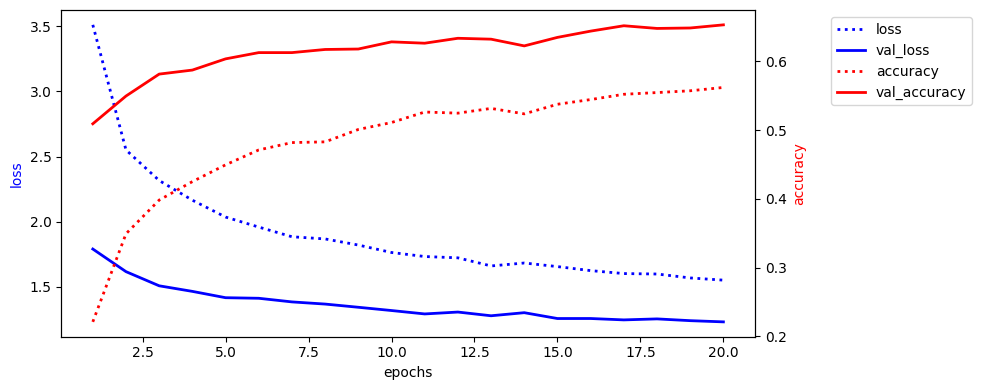

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_18 (Rescaling)    (None, 128, 128, 3)          0         ['input_14[0][0]']            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 24)           648       ['rescaling_18[0][0]']        
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 24)           96        ['stem_conv[0][0]']           
 n)                                                                                        

In [156]:
from tensorflow.keras.applications import EfficientNetV2S 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model_2():
    base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=NUM_CLASSES)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

run_evaluation("model_2", build_model_2, base_dir,
               train=True, train_generator=train_generator, valid_generator=valid_generator, epochs=20,
               batch_size=None, steps_per_epoch=train_generator.n//train_generator.batch_size,
               validation_steps = valid_generator.n//valid_generator.batch_size)

valid_accuracy_2 = 65.30
print("Model 2 accuracy:", valid_accuracy_2)

answer_2 = """
            It was decided to use EfficientNetV2S as the base model because it guarantees the extraction of complex features
            due to its advanced architecture. Freezing the base layers preserves these high-quality features, reducing the 
            risk of overfitting on new data. The addition of a global average pooling layer condenses spatial dimensions 
            while preserving essential information, followed by a dense layer with 'relu' activation to learn combinations 
            of high-level features. Batch normalisation and dropout further optimise training and combat overfitting, 
            keeping the model generalisable and efficient. 
           """
print("Answer is {} characters long".format(len(answer_2)))

In [157]:
validation.signature_unchanged(build_model_2)

## Part 3. Real-world evaluation (8 points)

In this part, you will collect your own indoor scenes images to extend the dataset and create a new test set. You can use your smartphone or any other camera. You should collect at least 200 images (10 classes and 20 images per class). Of course, respect other people's privacy when taking pictures. The images will not be shared publicly, only be used within this course, and deleted afterwards. 

Grading is done based on two pass-fail criteria: You will get 4 points if you correctly collect, preprocess, and upload the images, and 4 points if your model from part 1 or 2 can predict their classes with more than 50% accuracy.

### Question 3.1: Data acquisition (4 points)
Select 10 classes from the 67 available ones (choose the ones that you can reasonably take pictures of), and take at least 20 new images for each classes. E.g. if you choose 'kitchen', take at least 20 images of kitchens. Some be from the same kitchen from different angles. Take images that are of high quality (good lighting and representative for the class). Remember, your best model (created above) must be able to classify your own images with sufficient accuracy. You should NOT train on these images, they form an independent test set. Also, it's no use trying to overtune your model to your own images. 

The images must be stored in folders, one folder per image, as in the original Indoor Scenes dataset. After that, create a zip file `new_images.zip`. **Each image should be in the jpg format, and be less than 400 KB in size. The zip folder must also be less than 100 MB.** You are free in choosing what tools you use to preprocess the images. For instance, OpenCV can be used to easily load, resize, and store jpg images.

Hence, you should have the following folder structure:
<pre>
new_images.zip
|
└───new_images/
    |
    └───classname1/
    |      
    └───classname2/
    │
    ....
    │
    └───classname10/

</pre>

`classname1` to `classname10` folders must match the same class names as the original indoor scenes dataset (e.g. 'kitchen'). The names must match and You cannot create new categories. Each `classname(i)` folder should contain 20 `.jpg` images with your own captured pictures showing example of class `classname(i)`. For testing, we provide you with a function `load_new_data` that unzips your archive and creates a new pandas dataframe keeping the same structure as the original dataframe, so you can feed it to your model as test data. Note that you MUST use the provided folder structure for the function to work properly.

We've included a file 'new_images_example.zip' to show you what this zip file should look like.
 
Note: if your OS includes extra files (e.g. '.DS_Store' in MacOS), remove them before zipping the `new_images` folder.

In [168]:
import os
from PIL import Image

def resize_image(input_path, output_path):
    """Resize the image to a max of 1024 pixels on the largest side."""
    with Image.open(input_path) as img:
        img.thumbnail((1024, 1024))
        img.save(output_path, "JPEG")

def process_folder(input_folder, output_folder):
    """Process all jpg files in a folder and its subfolders, resizing and copying them."""
    for root, dirs, files in os.walk(input_folder):
        # Replace the base part of `root` with `output_folder`
        output_base = root.replace(input_folder, output_folder, 1)
        for file in files:
            if file.lower().endswith('.jpg'):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_base, file)
                os.makedirs(output_base, exist_ok=True)
                resize_image(input_path, output_path)

# Example usage:
current_directory = os.getcwd()
input_folder = os.path.join(current_directory, 'new_images')
output_folder = os.path.join(current_directory, 'smallimages')
process_folder(input_folder, output_folder)

In [169]:
### Don't change this code
import zipfile

new_data_dir = "new_images"

def check_files_size(filenames):
  sizes = [os.path.getsize(os.path.join(new_data_dir, filename)) for filename in filenames]
  return sum(np.array(sizes) <= 400*1024) == len(filenames)

def load_new_data(filename="new_images.zip"):
  try:
    file = zipfile.ZipFile(os.path.join(base_dir, filename), "r")
    file.extractall()
    file.close()

    labeldict = dict(zip(df['Class_name'].unique(), df['Class_encoded'].unique()))
    class_folders = os.listdir(new_data_dir)

    csvlist = []
    for class_folder in class_folders:
      images=[os.path.join(class_folder, elem) for elem in os.listdir(os.path.join(new_data_dir, class_folder))]

      if not check_files_size(images):
        shout("At least one image is larger than 400 KB. You must ensure all images have a size lower than 400KB to get points for this part.")
        return None
      
      csvlist+=list(zip(images, np.repeat(class_folder, len(images)), np.repeat(labeldict[class_folder], len(images))))
    
    return pd.DataFrame(csvlist,columns=["Filename","Class_name", "Class_encoded"])
  
  except FileNotFoundError:
    shout("The zip file with your images could not be found. Is it in the right folder, and named correctly?")
  except zipfile.BadZipFile:
    shout("The zip file is corrupt. Please upload a valid zip file.")

def check_loaded_images(dataframe):
  df_sub = dataframe.sample(10)
  X_rand_train = [cv2.imread(os.path.join(new_data_dir, filename)) for filename in df_sub['Filename'].to_numpy()]
  y_rand_train = df_sub['Class_name'].to_numpy()
  plot_images(X_rand_train, y_rand_train)
  print(df_sub)

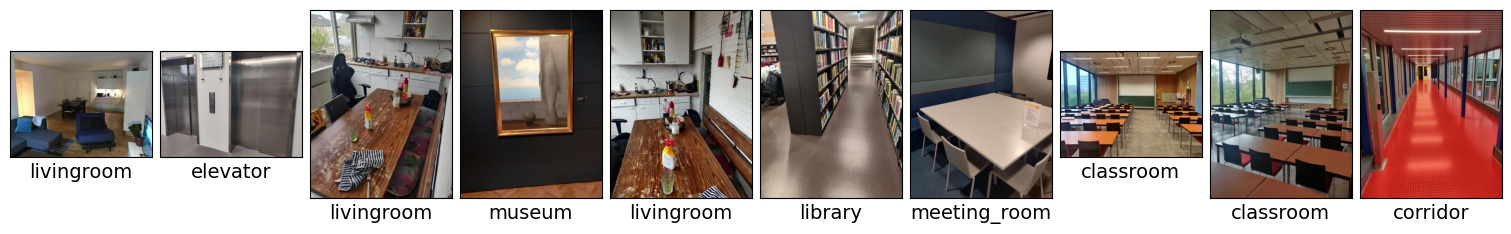

                        Filename    Class_name Class_encoded
79       livingroom\living_9.jpg    livingroom            41
56       elevator\elevator_6.jpg      elevator            23
78       livingroom\living_8.jpg    livingroom            41
99           museum\museum_9.jpg        museum            47
73       livingroom\living_3.jpg    livingroom            41
60         library\library_1.jpg       library            40
88  meeting_room\meet_room_8.jpg  meeting_room            45
32     classroom\classroom_2.jpg     classroom            13
37     classroom\classroom_7.jpg     classroom            13
48       corridor\corridor_8.jpg      corridor            19


In [170]:
# Make sure that new_df has the same structure as the original dataframe (shown in the beginning of the notebook)
# Replace the filename with new_images_example.zip if you want to test the function with the example images 
new_df = load_new_data("new_images.zip")
if new_df is not None:
    check_loaded_images(new_df)

Run the following to test whether you've included your images correctly.

### Question 3.2: Evaluate your own model on your own data (4 points)
* Implement a function `build_test_generator` that returns a test generator for the 200 images you just collected. You will need to tell the generator what the correct ordering of classes is (used for training your previous models).
* Implement a function `evaluate_on_test` that loads your best model from Part 2 (or 1) and uses it to predict the classes of your own images. Return the test accuracy in `test_accuracy_3`.

In [171]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import numpy as np

#Implement
def build_test_generator(test_data, test_data_dir):
    """ Returns a test generator for the 200 images you just collected
    Keyword arguments:
    test_data -- the DataFrame with the test data
    test_data_dir -- the directory where the test images are stored
    """
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_dataframe(
        x_col="Filename",
        y_col="Class_encoded",
        dataframe=test_data,
        directory=test_data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        classes=classes_ordered,
        class_mode="categorical",
        shuffle=False
    )
    
    return test_generator

def evaluate_on_test(test_generator, model_name):
    """ Evaluates the given model on given test data and returns the accuracy
    Keyword arguments:
    test_generator -- the generator for the test data
    model_name -- the name of the model to load
    """
    model = load_model_from_file(base_dir, model_name)
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_generator.classes, predicted_classes)
    return accuracy

test_generator = build_test_generator(new_df, new_data_dir)
test_accuracy_3 = evaluate_on_test(test_generator, "model_2")
print("Part 3 test accuracy:", test_accuracy_3)

Found 100 validated image filenames belonging to 67 classes.


4/4 [==============================] - 11s 525ms/step
Part 3 test accuracy: 0.59


In [162]:
validation.signature_unchanged(build_test_generator)

In [163]:
validation.signature_unchanged(evaluate_on_test)

## Part 4. Classroom challenge (10 points)
The final part of this assignment is a small classroom challenge. The start will be announced next week. For this challenge, you will receive code (in a separate notebook) to build deep learning models, train them on a given dataset, and then submit your model to the OpenML platform. This will be graded as follows:
* 5 points: Evaluation of your model on the Indoor Scenes dataset, albeit on different data splits than you have used so far. Still, your best models for Part 1 and 2 will likely performs similarly well. A leaderboard will show how well your models perform compared to the others in class. After the assignment, you will also be able to see how the best models were created. This question will be graded on a curve, with the same expected performance as in Part 2, and the highest grade being given to the best submitted model.
* 5 points: Evaluation of your best submitted model on the joined test data created by your fellow students. That is, we will create a new hidden test set out of all submitted new real-world images by all students, and evaluate your model_2 on how well it performs on that. This question will be graded on a curve, with the highest grade being given to the best submitted model. There is nothing you need to do for this except submitting your model to GitHub in Part 2.

We start this last part a bit later so that everyone has a chance to already explore the dataset and possible models. There will be plenty of time to submit your models.

Good luck!